In [6]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np

2.5.1


# Q3.5

In [ ]:

seed = 4053
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# data [0,255] -> [0,1] ->[-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [10]:
image, label = trainset[0]     # get 1st image and label
print(image.shape)             

torch.Size([3, 32, 32])


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # after it, 16 X 32 x 32
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  
        # after it, 16 X 32 x 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) 
        # # of channels keep unchanged, width and height become half
        # 32 x 16 x 16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)   
        # output shape of fc =  10
        self.fc = nn.Linear(32 * 16 * 16, 10)                      
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        # x.size(0) get batch_size,
        # x.view(x.size(0), -1): [B, C, H, W] -> [B, C * H * W]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loss_list, test_loss_list, train_acc_list, test_acc_list = [], [], [], []
for epoch in range(10):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = total_loss / total
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    test_loss_list.append(val_loss)
    test_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/10] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

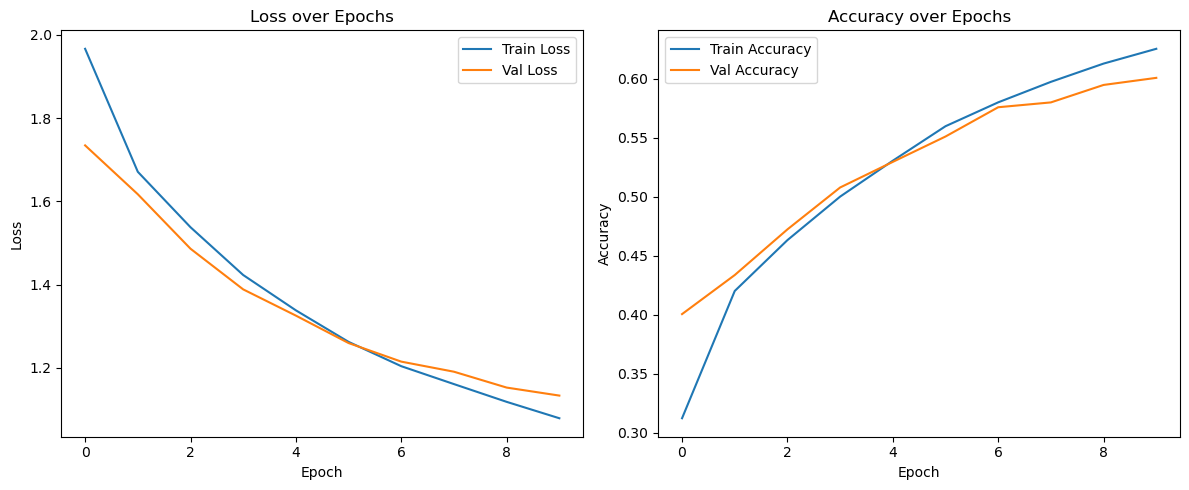

In [17]:
# visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# Q3.6

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # within each channel do batch norm
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 16 * 16, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loss_list, test_loss_list, train_acc_list, test_acc_list = [], [], [], []

for epoch in range(10):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = total_loss / total
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    test_loss_list.append(val_loss)
    test_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/10] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/10] - Train Loss: 1.7627, Train Acc: 0.4061 | Val Loss: 1.3393, Val Acc: 0.5234
Epoch [2/10] - Train Loss: 1.3518, Train Acc: 0.5150 | Val Loss: 1.2123, Val Acc: 0.5661
Epoch [3/10] - Train Loss: 1.2341, Train Acc: 0.5590 | Val Loss: 1.1643, Val Acc: 0.5820
Epoch [4/10] - Train Loss: 1.1642, Train Acc: 0.5884 | Val Loss: 1.0893, Val Acc: 0.6216
Epoch [5/10] - Train Loss: 1.1167, Train Acc: 0.6062 | Val Loss: 1.0445, Val Acc: 0.6411
Epoch [6/10] - Train Loss: 1.0860, Train Acc: 0.6172 | Val Loss: 1.0346, Val Acc: 0.6505
Epoch [7/10] - Train Loss: 1.0517, Train Acc: 0.6297 | Val Loss: 1.0179, Val Acc: 0.6490
Epoch [8/10] - Train Loss: 1.0256, Train Acc: 0.6384 | Val Loss: 1.0185, Val Acc: 0.6444
Epoch [9/10] - Train Loss: 1.0069, Train Acc: 0.6471 | Val Loss: 1.0017, Val Acc: 0.6622
Epoch [10/10] - Train Loss: 0.9965, Train Acc: 0.6528 | Val Loss: 1.0105, Val Acc: 0.6503


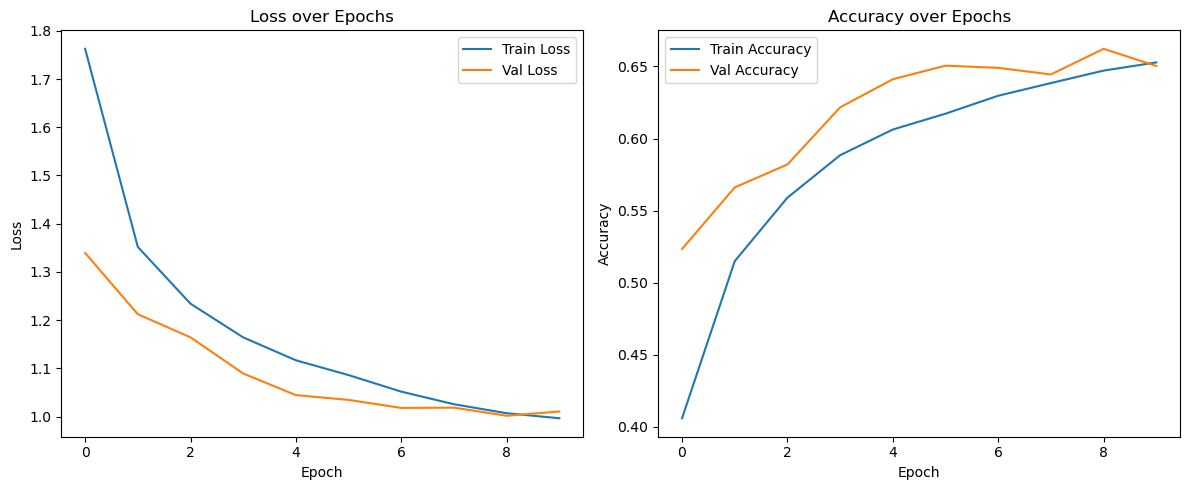

In [19]:
# visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()